In [1]:
import os
import zarr
import random
import json
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset


class CFG:
    particles_name = [
        "apo-ferritin",
        "beta-amylase",
        "beta-galactosidase",
        "ribosome",
        "thyroglobulin",
        "virus-like-particle",
    ]

    resolution2ratio = {
        "A": 1 / 10,
        "0": 1,
        "1": 2,
        "2": 4,
    }

    particles2cls = {
        "none": 0,
        "apo-ferritin": 1,
        "beta-amylase": 2,
        "beta-galactosidase": 3,
        "ribosome": 4,
        "thyroglobulin": 5,
        "virus-like-particle": 6,
    }
    cls2particles = {
        0: "none",
        1: "apo-ferritin",
        2: "beta-amylase",
        3: "beta-galactosidase",
        4: "ribosome",
        5: "thyroglobulin",
        6: "virus-like-particle",
    }

    particle_radius = {
        "apo-ferritin": 60,
        "beta-amylase": 65,
        "beta-galactosidase": 90,
        "ribosome": 150,
        "thyroglobulin": 130,
        "virus-like-particle": 135,
    }

    particle_weights = {
        "apo-ferritin": 1,
        "beta-amylase": 0,
        "beta-galactosidase": 2,
        "ribosome": 1,
        "thyroglobulin": 2,
        "virus-like-particle": 1,
    }

    colormap = {
        # -1の場合は透明の色
    }


def read_zarr(zarr_pth, resolution="0"):
    zarr_store = zarr.open(zarr_pth, mode="r")

    tomogram = zarr_store[resolution][:]

    return tomogram


def read_info_json(
    base_dir="../inputs/train/overlay/ExperimentRuns/",
    exp_name="TS_5_4",
    particle_name="apo-ferritin",
):

    keys = set(
        [
            "apo-ferritin",
            "beta-amylase",
            "beta-galactosidase",
            "ribosome",
            "thyroglobulin",
            "virus-like-particle",
        ]
    )

    if particle_name not in keys:
        raise ValueError(
            f"Particle name should be one of the following: {keys}. Got {particle_name}."
        )

    read_json_path = os.path.join(base_dir, exp_name, "Picks", f"{particle_name}.json")

    with open(read_json_path, "r") as f:
        particle_info = json.load(f)

    coords = []
    for point in particle_info["points"]:
        coords.append(
            [point["location"]["z"], point["location"]["y"], point["location"]["x"]]
        )

    coords = np.array(coords)

    return coords


def scale_coordinates(coords, tomogram_shape, resolution):
    """Scale coordinates to match tomogram dimensions."""
    scaled_coords = coords.copy()

    # scaled_coords[:, 0] = coords[:, 0] / 10  # / coords[:, 0].max() * tomogram_shape[0]
    # scaled_coords[:, 1] = coords[:, 1] / 10  # / coords[:, 1].max() * tomogram_shape[1]
    # scaled_coords[:, 2] = coords[:, 2] / 10  # / coords[:, 2].max() * tomogram_shape[2]

    resolution_info = CFG.resolution2ratio
    scaled_coords[:, 0] = (
        coords[:, 0] * resolution_info["A"] / resolution_info[resolution]
    )
    scaled_coords[:, 1] = (
        coords[:, 1] * resolution_info["A"] / resolution_info[resolution]
    )
    scaled_coords[:, 2] = (
        coords[:, 2] * resolution_info["A"] / resolution_info[resolution]
    )

    return scaled_coords


def create_dataset(
    zarr_type="ctfdeconvolved",
    base_dir="../../inputs/train/",
    exp_name="TS_5_4",
    resolution="0",
    particle_names=[],
):
    zarr_name = f"{zarr_type}.zarr"
    zarr_pth = os.path.join(
        base_dir, "static/ExperimentRuns", exp_name, "VoxelSpacing10.000/", zarr_name
    )
    tomogram = read_zarr(zarr_pth, resolution=resolution)

    particle_info = {"corrds": {}, "scaled_corrds": {}}
    for particle_name in particle_names:
        coords = read_info_json(
            os.path.join(base_dir, "overlay/ExperimentRuns/"), exp_name, particle_name
        )
        scaled_coords = scale_coordinates(coords, tomogram.shape, resolution)
        particle_info["corrds"][particle_name] = coords
        particle_info["scaled_corrds"][particle_name] = scaled_coords

    return tomogram, particle_info


def normalise_by_percentile(data, min=5, max=99):
    min = np.percentile(data, min)
    max = np.percentile(data, max)
    data = (data - min) / (max - min)
    return data, min, max


class EziiDataset(Dataset):
    def __init__(
        self,
        exp_names=[],
        base_dir="../../inputs/train/static",
        particles_name=CFG.particles_name,
        resolution="0",
        zarr_type=["ctfdeconvolved"],
    ):
        self.exp_names = exp_names
        self.base_dir = base_dir
        self.particles_name = particles_name
        self.resolution = resolution
        self.zarr_type = zarr_type

        # exp_namesとzarr_typeの総当たりでデータを作成
        self.data = []
        for exp_name in exp_names:
            for type_ in zarr_type:
                self.data.append((exp_name, type_))

        print(self.data)

    def __getitem__(self, i):
        exp_name, type_ = self.data[i]  # TS_6_6

        tomogram, particle_info = create_dataset(
            particle_names=self.particles_name,
            resolution=self.resolution,
            exp_name=exp_name,
            zarr_type=type_,
        )

        normalized_tomogram, min, max = normalise_by_percentile(tomogram)
        apo_ferritin = particle_info["scaled_corrds"]["apo-ferritin"]
        beta_amylase = particle_info["scaled_corrds"]["beta-amylase"]
        beta_galactosidase = particle_info["scaled_corrds"]["beta-galactosidase"]
        ribosome = particle_info["scaled_corrds"]["ribosome"]
        thyroglobulin = particle_info["scaled_corrds"]["thyroglobulin"]
        virus_like_particle = particle_info["scaled_corrds"]["virus-like-particle"]

        prticle_corrds = {
            "apo-ferritin": apo_ferritin,
            "beta-amylase": beta_amylase,
            "beta-galactosidase": beta_galactosidase,
            "ribosome": ribosome,
            "thyroglobulin": thyroglobulin,
            "virus-like-particle": virus_like_particle,
        }

        segmentation_map = create_segmentation_map(
            tomogram, resolution=self.resolution, particle_coords=prticle_corrds
        )

        tomogram = padding(tomogram, self.resolution)
        normalized_tomogram = padding(normalized_tomogram, self.resolution)
        segmentation_map = padding(segmentation_map, self.resolution)

        return {
            "resolution": self.resolution,
            "exp_name": exp_name,
            "tomogram": tomogram,
            "normalized_tomogram": normalized_tomogram,
            "segmentation_map": segmentation_map,
            "apo_ferritin": apo_ferritin,
            "beta_amylase": beta_amylase,
            "beta_galactosidase": beta_galactosidase,
            "ribosome": ribosome,
            "thyroglobulin": thyroglobulin,
            "virus_like_particle": virus_like_particle,
            "particle_corrds": prticle_corrds,
        }

    def __len__(self):
        return len(self.data)


def padding(tomogram, resolution):
    if resolution == "0":  # 184, 630, 630 -> 184, 640, 640
        tomogram = np.pad(tomogram, ((0, 0), (5, 5), (5, 5)), mode="constant")
        return tomogram
    elif resolution == "1":  # 92, 315, 315 -> 92, 320, 320
        tomogram = np.pad(tomogram, ((0, 0), (2, 3), (2, 3)), mode="constant")
        return tomogram
    elif resolution == "2":  # 46, 158, 158 -> 46, 160, 160
        tomogram = np.pad(tomogram, ((0, 0), (1, 1), (1, 1)), mode="constant")
        return tomogram
    raise ValueError(
        f"Resolution should be one of the following: 0, 1, 2. Got {resolution}."
    )


def create_segmentation_map(tomogram, resolution, particle_coords={}):
    segmentation_map = np.zeros_like(tomogram)
    segmentation_map[:, :, :] = 0

    particle_radius = (
        CFG.particle_radius
    )  # {apo-ferritin: 60, beta-amylase: 65, beta-galactosidase: 90, ribosome: 150, thyroglobulin: 130, virus-like-particle: 135}
    particle2cls = CFG.particles2cls
    resolution_info = CFG.resolution2ratio  # {A: 1/10, 0: 1, 1: 2, 2: 4}

    r_by_particle = {}
    for particle_name, r in particle_radius.items():
        r_by_particle[particle_name] = (
            r * resolution_info["A"] / resolution_info[resolution]
        )

    for i, (paraticle_name, coords) in enumerate(particle_coords.items()):
        # print(coords.shape)
        for z, y, x in coords:
            z, y, x = int(z), int(y), int(x)
            cls = particle2cls[paraticle_name]
            r = r_by_particle[paraticle_name]
            z_min = int(max(0, z - r))
            z_max = int(min(tomogram.shape[0], z + r))
            y_min = int(max(0, y - r))
            y_max = int(min(tomogram.shape[1], y + r))
            x_min = int(max(0, x - r))
            x_max = int(min(tomogram.shape[2], x + r))

            # x,y,zを中心に円計上にクラスを埋める
            # segmentation_map[z_min:z_max, y_min:y_max, x_min:x_max] = cls
            for z_ in range(z_min, z_max):
                for y_ in range(y_min, y_max):
                    for x_ in range(x_min, x_max):
                        if (z - z_) ** 2 + (y - y_) ** 2 + (x - x_) ** 2 < r**2:
                            segmentation_map[z_, y_, x_] = cls

    return segmentation_map

[('TS_5_4', 'ctfdeconvolved')]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


903077

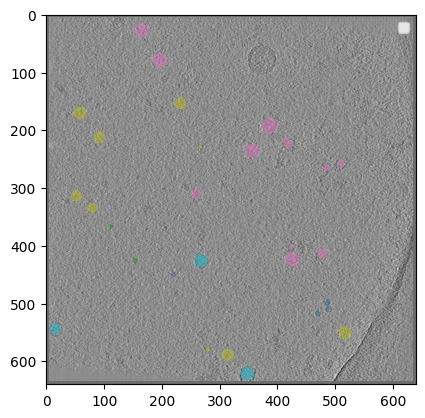

In [2]:
dataset = EziiDataset(
    exp_names=["TS_5_4"],
    base_dir="../../inputs/train/static",
    particles_name=CFG.particles_name,
    resolution="0",
)
normalized_tomogram = dataset[0]["normalized_tomogram"]
segmentation_map = dataset[0]["segmentation_map"]

# まずはトモグラムを表示
index = 100
plt.imshow(normalized_tomogram[index], cmap="gray")

# 重ねてクラスが存在する部分を色付け(-1の部分は透明)
target_segmentation_map = segmentation_map[index]
masked_seg = np.ma.masked_where(target_segmentation_map <= 0, target_segmentation_map)

plt.imshow(masked_seg, cmap="tab10", alpha=0.5)
plt.legend()

# for i in range(target_segmentation_map.shape[0]):
#     for j in range(target_segmentation_map.shape[1]):
#         label = target_segmentation_map[i, j]
#         if label != -1:
#             plt.scatter(j, i, alpha=0.9, c=label)
#             cnt += 1
len(segmentation_map[segmentation_map > 0])

[('TS_6_4', 'ctfdeconvolved')]


20110

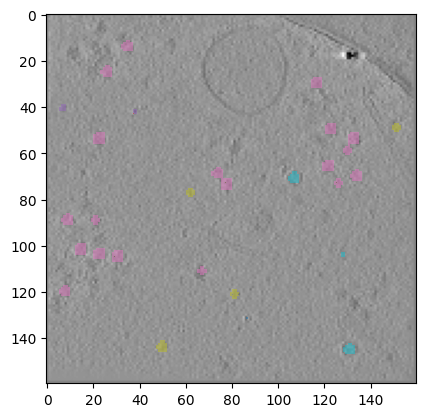

In [3]:
dataset = EziiDataset(
    exp_names=["TS_6_4"],
    base_dir="../../inputs/train/static",
    particles_name=CFG.particles_name,
    resolution="2",
)
normalized_tomogram = dataset[0]["normalized_tomogram"]
segmentation_map = dataset[0]["segmentation_map"]

# まずはトモグラムを表示
index = 21
plt.imshow(normalized_tomogram[index], cmap="gray")

# 重ねてクラスが存在する部分を色付け(-1の部分は透明)
target_segmentation_map = segmentation_map[index]
masked_seg = np.ma.masked_where(target_segmentation_map <= 0, target_segmentation_map)

plt.imshow(masked_seg, cmap="tab10", alpha=0.5)

# for i in range(target_segmentation_map.shape[0]):
#     for j in range(target_segmentation_map.shape[1]):
#         label = target_segmentation_map[i, j]
#         if label != -1:
#             plt.scatter(j, i, alpha=0.9, c=label)
#             cnt += 1
len(segmentation_map[segmentation_map > 0])

In [4]:
import torch
import torch.nn as nn
from icecream import ic
import segmentation_models_pytorch as smp


class UNet_2D(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = smp.Unet(
            encoder_name="efficientnet-b7",
            encoder_weights="imagenet",
            in_channels=1,
            classes=len(CFG.particles2cls),
        )

    def forward(self, x):

        x = self.model(x)

        return x

In [5]:
train_dataset = EziiDataset(
    exp_names=["TS_5_4", "TS_73_6", "TS_99_9", "TS_6_4", "TS_69_2"],
    base_dir="../../inputs/train/static",
    particles_name=CFG.particles_name,
    resolution="0",
    # zarr_type=["ctfdeconvolved"],
    zarr_type=["denoised", "ctfdeconvolved", "wbp", "isonetcorrected"],
)

valid_dataset = EziiDataset(
    exp_names=["TS_86_3", "TS_6_6"],
    base_dir="../../inputs/train/static",
    particles_name=CFG.particles_name,
    resolution="0",
    # zarr_type=["ctfdeconvolved"],
    zarr_type=["denoised"],
)

from tqdm import tqdm

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False)

for data in tqdm(train_dataset):
    normalized_tomogram = data["normalized_tomogram"]
    segmentation_map = data["segmentation_map"]
    break

# normalized_tomogram =
normalized_tomogram.shape[0]

[('TS_5_4', 'denoised'), ('TS_5_4', 'ctfdeconvolved'), ('TS_5_4', 'wbp'), ('TS_5_4', 'isonetcorrected'), ('TS_73_6', 'denoised'), ('TS_73_6', 'ctfdeconvolved'), ('TS_73_6', 'wbp'), ('TS_73_6', 'isonetcorrected'), ('TS_99_9', 'denoised'), ('TS_99_9', 'ctfdeconvolved'), ('TS_99_9', 'wbp'), ('TS_99_9', 'isonetcorrected'), ('TS_6_4', 'denoised'), ('TS_6_4', 'ctfdeconvolved'), ('TS_6_4', 'wbp'), ('TS_6_4', 'isonetcorrected'), ('TS_69_2', 'denoised'), ('TS_69_2', 'ctfdeconvolved'), ('TS_69_2', 'wbp'), ('TS_69_2', 'isonetcorrected')]
[('TS_86_3', 'denoised'), ('TS_6_6', 'denoised')]


  0%|          | 0/20 [00:02<?, ?it/s]


184

In [6]:
import torch
import torchvision.transforms.functional as F
import random


def aug(input_, gt):
    """
    画像(input_)とセグメンテーションマップ(gt)にデータ拡張を適用する関数。

    Args:
        input_ (torch.Tensor): 入力画像 (batch_size, 1, H, W)。
        gt (torch.Tensor): セグメンテーションマップ (batch_size, H, W)。

    Returns:
        torch.Tensor, torch.Tensor: データ拡張後の画像とセグメンテーションマップ。
    """
    # 確率的に適用されるデータ拡張を定義
    transforms = [
        lambda img, mask: (
            (F.hflip(img), F.hflip(mask)) if random.random() > 0.5 else (img, mask)
        ),
        lambda img, mask: (
            (F.vflip(img), F.vflip(mask)) if random.random() > 0.5 else (img, mask)
        ),
        lambda img, mask: (
            (
                F.rotate(
                    img,
                    angle=random.choice([0, 90, 180, 270]),
                    interpolation=F.InterpolationMode.NEAREST,
                ),
                F.rotate(
                    mask,
                    angle=random.choice([0, 90, 180, 270]),
                    interpolation=F.InterpolationMode.NEAREST,
                ),
            )
            if random.random() > 0.5
            else (img, mask)
        ),
    ]

    # バッチ単位で処理
    augmented_inputs, augmented_gts = [], []
    for i in range(input_.size(0)):
        img, mask = input_[i], gt[i]

        # 変換前に次元を変換
        img = img.permute(1, 2, 0)  # (1, H, W) -> (H, W, 1)
        mask = mask.unsqueeze(-1)  # (H, W) -> (H, W, 1)

        for t in transforms:
            img, mask = t(img, mask)

        # 変換後に次元を元に戻す
        img = img.permute(2, 0, 1)  # (H, W, 1) -> (1, H, W)
        mask = mask.squeeze(-1)  # (H, W, 1) -> (H, W)

        augmented_inputs.append(img)
        augmented_gts.append(mask)

    # バッチを再結合して返す
    return torch.stack(augmented_inputs), torch.stack(augmented_gts)


input_ = torch.rand(1, 1, 46, 160)
gt = torch.randint(0, 7, (1, 46, 160))

augmented_input, augmented_gt = aug(input_, gt)

Valid-Epoch: 0, Loss: 0.46454777305378864: 100%|██████████| 368/368 [00:31<00:00, 11.80it/s]


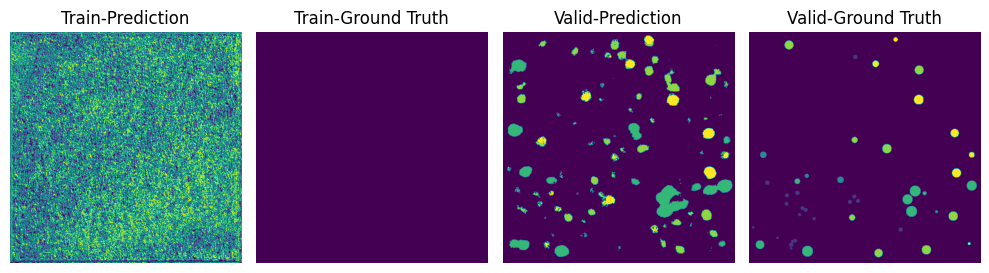

Epoch: 0, Loss: 0.09852859377861023


Valid-Epoch: 1, Loss: 0.5261206407018978: 100%|██████████| 368/368 [01:05<00:00,  5.63it/s] 


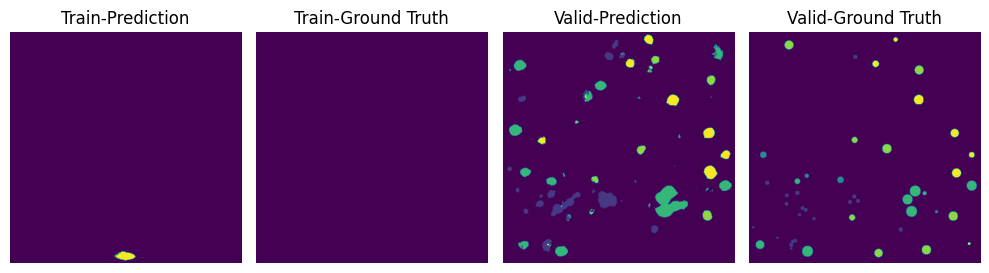

Epoch: 1, Loss: 0.028558962047100067


Valid-Epoch: 2, Loss: 0.6476938409487838: 100%|██████████| 368/368 [01:13<00:00,  4.99it/s]


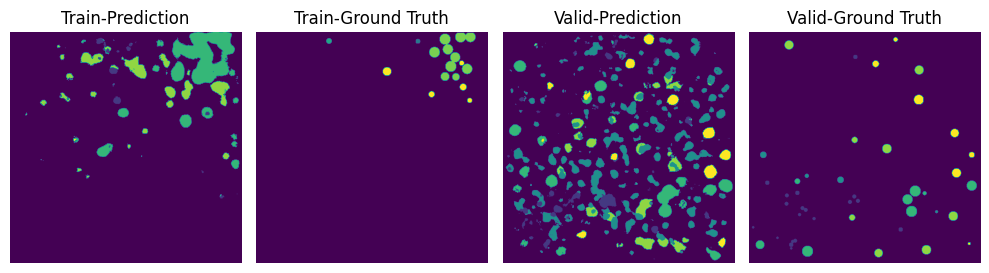

Epoch: 2, Loss: 0.026716893538832664


Valid-Epoch: 3, Loss: 0.5565797564492602: 100%|██████████| 368/368 [01:00<00:00,  6.04it/s] 


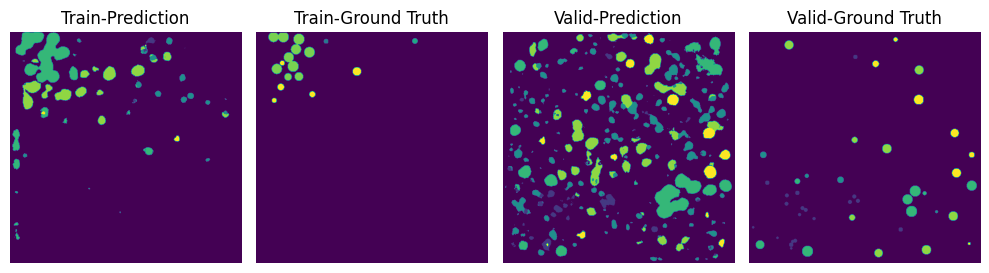

Epoch: 3, Loss: 0.0131621602922678


Valid-Epoch: 4, Loss: 0.601009959013343: 100%|██████████| 368/368 [00:57<00:00,  6.44it/s] 


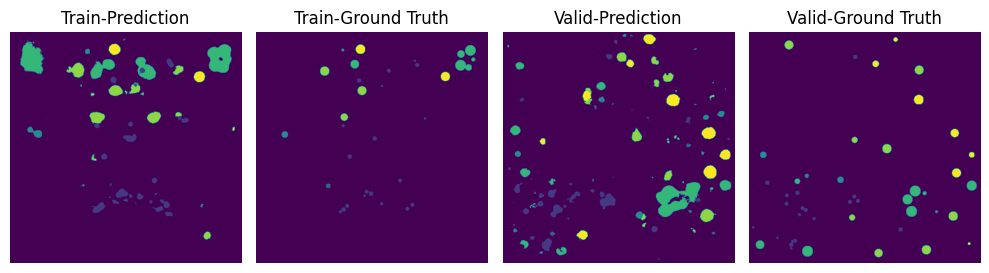

Epoch: 4, Loss: 0.012308853678405285


Valid-Epoch: 5, Loss: 0.7288289007062659: 100%|██████████| 368/368 [01:12<00:00,  5.10it/s]


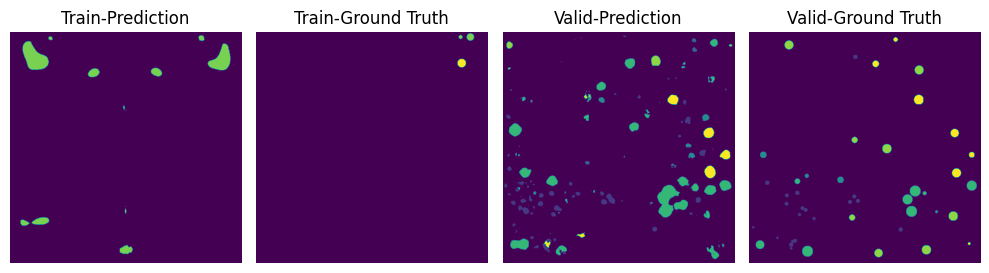

Epoch: 5, Loss: 0.00791072566062212


Valid-Epoch: 6, Loss: 0.871230722868147: 100%|██████████| 368/368 [01:08<00:00,  5.37it/s]  


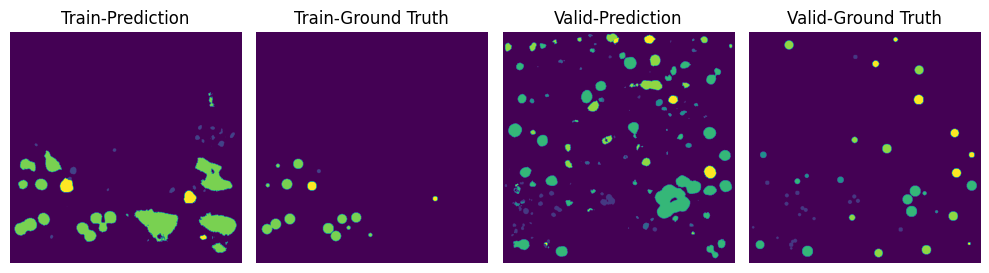

Epoch: 6, Loss: 0.009494108147919178


Valid-Epoch: 7, Loss: 0.840338725496701: 100%|██████████| 368/368 [01:10<00:00,  5.23it/s] 


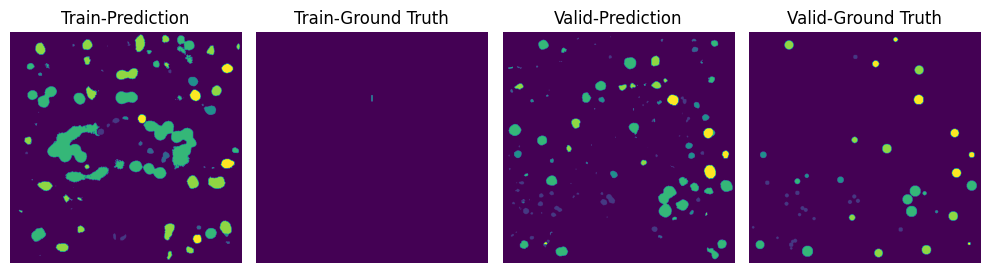

Epoch: 7, Loss: 0.0051007699221372604


Valid-Epoch: 8, Loss: 0.8340912091725445: 100%|██████████| 368/368 [01:15<00:00,  4.90it/s]


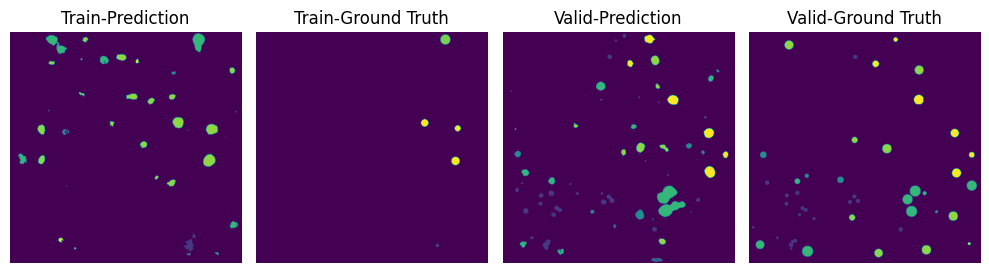

Epoch: 8, Loss: 0.006816196255385876


Valid-Epoch: 9, Loss: 0.8467765728716546: 100%|██████████| 368/368 [01:16<00:00,  4.84it/s]


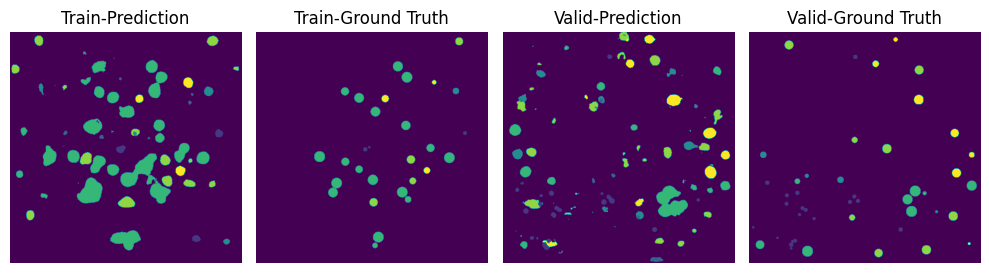

Epoch: 9, Loss: 0.0038952105678617954


Train-Epoch: 10, Loss: 0.2756610427371631:  40%|████      | 495/1226 [23:51<37:35,  3.09s/it]   

In [ ]:
model = UNet_2D().to("cuda")
model.eval()


def save_images(
    train_pred_tomogram,
    train_gt_tomogram,
    valid_pred_tomogram,
    valid_gt_tomogram,
    save_dir="images",
    epoch=0,
):
    import os

    train_save_dir = os.path.join(save_dir, f"epoch_{epoch}", "train")
    valid_save_dir = os.path.join(save_dir, f"epoch_{epoch}", "valid")
    os.makedirs(train_save_dir, exist_ok=True)
    os.makedirs(valid_save_dir, exist_ok=True)
    # 可視化
    for i in range(len(train_pred_tomogram)):
        train_pred = train_pred_tomogram[i].argmax(1).squeeze(0)
        train_gt = train_gt_tomogram[i].squeeze(0)

        plt.figure(figsize=(10, 5))

        # 2つの画像を並べて表示
        ax = plt.subplot(1, 2, 1)
        ax.imshow(train_pred, cmap="tab10")
        ax.set_title("Train-Prediction")
        ax.axis("off")

        ax = plt.subplot(1, 2, 2)
        ax.imshow(train_gt, cmap="tab10")
        ax.set_title("Train-Ground Truth")
        ax.axis("off")

        plt.savefig(os.path.join(train_save_dir, f"train_{i}.png"))
        plt.close()

    for i in range(len(valid_pred_tomogram)):
        valid_pred = valid_pred_tomogram[i].argmax(1).squeeze(0)
        valid_gt = valid_gt_tomogram[i].squeeze(0)

        plt.figure(figsize=(10, 5))

        # 2つの画像を並べて表示
        ax = plt.subplot(1, 2, 1)
        ax.imshow(valid_pred, cmap="tab10")
        ax.set_title("Valid-Prediction")
        ax.axis("off")

        ax = plt.subplot(1, 2, 2)
        ax.imshow(valid_gt, cmap="tab10")
        ax.set_title("Valid-Ground Truth")
        ax.axis("off")

        plt.savefig(os.path.join(valid_save_dir, f"valid_{i}.png"))
        plt.close()


optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss(
    weight=torch.tensor([0.5, 32, 32, 32, 32, 32, 32]).to("cuda")
)
# criterion = DiceLoss()

best_model = None
best_loss = np.inf
batch_size = 3

for epoch in range(100):
    train_loss = []
    valid_loss = []
    train_pred_tomogram = []
    train_gt_tomogram = []
    model.train()
    tq = tqdm(range(len(train_loader) * normalized_tomogram.shape[0] // batch_size))
    for data in train_loader:
        tomogram = data["normalized_tomogram"]
        segmentation_map = data["segmentation_map"].long()

        for i in range(batch_size, tomogram.shape[1], batch_size):
            optimizer.zero_grad()
            from_, to_ = 0, tomogram.shape[1]
            random_index = random.sample(range(from_, to_), batch_size)
            input_ = tomogram[:, random_index]
            input_ = input_.permute(1, 0, 2, 3)  # (batch_size, 1, 160, 160)
            gt = segmentation_map[:, random_index].squeeze()  # (batch_size, 160, 160)

            input_, gt = aug(input_, gt)

            input_ = input_.to("cuda")
            gt = gt.to("cuda")
            output = model(input_)
            loss = criterion(output, gt)

            # for i in range(batch_size):
            #     ic(output[i].shape, gt[i].shape) # torch.Size([1, 7, 160, 160]) torch.Size([1, 160, 160])
            #     loss = criterion(output[i].unsqueeze(0), gt[i].unsqueeze(0))
            #     loss.backward()
            #     optimizer.step()

            #     train_loss.append(loss.item())
            #     tq.set_description(f"Train-Epoch: {epoch}, Loss: {np.mean(train_loss)}")
            #     tq.update(1)

            #     train_pred_tomogram.append(output.cpu().detach().numpy())
            #     train_gt_tomogram.append(gt.cpu().detach().numpy())

            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())
            tq.set_description(f"Train-Epoch: {epoch}, Loss: {np.mean(train_loss)}")
            tq.update(1)

            for i in range(batch_size):
                train_pred_tomogram.append(output[i].cpu().detach().numpy())
                train_gt_tomogram.append(gt[i].cpu().detach().numpy())
    tq.close()

    ############################################# valid #############################################

    valid_pred_tomogram = []
    valid_gt_tomogram = []
    model.eval()
    tq = tqdm(range(len(valid_loader) * normalized_tomogram.shape[0]))
    for data in valid_loader:
        tomogram = data["normalized_tomogram"].to("cuda")
        segmentation_map = data["segmentation_map"].to("cuda").long()

        for i in range(tomogram.shape[1]):
            input_ = tomogram[:, i].unsqueeze(0)
            gt = segmentation_map[:, i]

            output = model(input_)
            loss = criterion(output, gt)

            valid_loss.append(loss.item())
            tq.set_description(f"Valid-Epoch: {epoch}, Loss: {np.mean(valid_loss)}")
            tq.update(1)

            valid_pred_tomogram.append(output.cpu().detach().numpy())
            valid_gt_tomogram.append(gt.cpu().detach().numpy())
    tq.close()

    if np.mean(valid_loss) < best_loss:
        best_loss = np.mean(valid_loss)
        best_model = model
        torch.save(best_model.state_dict(), "best_model.pth")

    # 可視化
    index = 50

    # 2つの画像を並べて表示
    plt.figure(figsize=(10, 5))

    # 2つの画像を並べて表示
    ax = plt.subplot(1, 4, 1)
    ax.imshow(train_pred_tomogram[index].argmax(0))
    ax.set_title("Train-Prediction")
    ax.axis("off")

    ax = plt.subplot(1, 4, 2)
    ax.imshow(train_gt_tomogram[index])
    ax.set_title("Train-Ground Truth")
    ax.axis("off")

    ax = plt.subplot(1, 4, 3)
    ax.imshow(valid_pred_tomogram[index].argmax(1).squeeze(0))
    ax.set_title("Valid-Prediction")
    ax.axis("off")

    ax = plt.subplot(1, 4, 4)
    ax.imshow(valid_gt_tomogram[index].squeeze(0))
    ax.set_title("Valid-Ground Truth")
    ax.axis("off")

    # Adjust layout to prevent overlap
    plt.tight_layout()

    plt.show()

    # save_images(
    #     train_gt_tomogram=train_gt_tomogram,
    #     train_pred_tomogram=train_pred_tomogram,
    #     valid_gt_tomogram=valid_gt_tomogram,
    #     valid_pred_tomogram=valid_pred_tomogram,
    #     save_dir="images",
    #     epoch=epoch,
    # )

    print(f"Epoch: {epoch}, Loss: {loss.item()}")